In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhoogla/unswnb15")

df=pd.read_parquet(path)
df.head()


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [3]:
# Drop non-numeric columns before calculating the correlation matrix
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Sort correlations with the 'label' column
if 'label' in correlation_matrix:
    print(correlation_matrix['label'].sort_values(ascending=False))
else:
    print("The 'label' column is not numeric or is missing in the correlation matrix.")



label                1.000000
ct_dst_sport_ltm     0.371672
rate                 0.335883
ct_src_dport_ltm     0.318518
sload                0.165249
dur                  0.029096
sbytes               0.019376
trans_depth          0.002246
sloss                0.001828
ackdat               0.000817
is_ftp_login        -0.008762
ct_ftp_cmd          -0.009092
ct_flw_http_mthd    -0.012237
sjit                -0.016436
response_body_len   -0.018930
tcprtt              -0.024668
smean               -0.028372
dinpkt              -0.030136
spkts               -0.043040
synack              -0.043250
djit                -0.048819
dbytes              -0.060403
dloss               -0.075961
dpkts               -0.097394
sinpkt              -0.155454
is_sm_ips_ports     -0.160126
dtcpb               -0.263543
stcpb               -0.266585
dmean               -0.295173
dwin                -0.339166
dload               -0.352169
swin                -0.364877
Name: label, dtype: float64


## stage 0 and 1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_fscore_support,
    precision_recall_curve, average_precision_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

class NetworkIntrusionModelComparator:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {
            "Decision Tree": DecisionTreeClassifier(random_state=random_state),
            "Random Forest": RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=random_state
            ),
            "Neural Network": None
        }
        self.encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.scaler = StandardScaler()
        self.results = {}
        self.X_train = self.X_test = self.y_train = self.y_test = None

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

    def _is_numeric_column(self, series):
        """Check if a column is numeric by attempting conversion to float."""
        try:
            pd.to_numeric(series, errors='raise')
            return True
        except (ValueError, TypeError):
            return False

    def preprocess_data(self, data, target_col="label", attack_cat_col="attack_cat", test_size=0.2):
        """
        Preprocess the network traffic data with enhanced error handling and validation.

        Parameters:
        -----------
        data : pandas.DataFrame
            Input dataset containing network traffic features
        target_col : str
            Name of the target column (default: "label")
        attack_cat_col : str
            Name of the attack category column to be dropped (default: "attack_cat")
        test_size : float
            Proportion of dataset to include in the test split (default: 0.2)

        Returns:
        --------
        tuple
            Processed (X_train, X_test, y_train, y_test)
        """
        logging.info("Starting data preprocessing...")

        # Input validation
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")

        required_cols = [target_col, attack_cat_col]
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        df = data.copy()

        # Handle infinite values
        df = df.replace([np.inf, -np.inf], np.nan)

        # Split features and target
        y = df[target_col]
        X = df.drop([target_col, attack_cat_col], axis=1)

        # Identify column types
        self.categorical_cols = [col for col in X.columns
                               if not self._is_numeric_column(X[col])]
        self.numerical_cols = [col for col in X.columns
                             if col not in self.categorical_cols]

        logging.info(f"Found {len(self.categorical_cols)} categorical and {len(self.numerical_cols)} numerical columns")

        # Enhanced missing value handling with logging
        for col in self.categorical_cols:
            missing = X[col].isna().sum()
            if missing > 0:
                mode_val = X[col].mode()[0]
                X[col].fillna(mode_val, inplace=True)
                logging.info(f"Filled {missing} missing values in {col} with mode: {mode_val}")

        for col in self.numerical_cols:
            missing = X[col].isna().sum()
            if missing > 0:
                median_val = X[col].median()
                X[col].fillna(median_val, inplace=True)
                logging.info(f"Filled {missing} missing values in {col} with median: {median_val}")

        # Feature processing
        if self.categorical_cols:
            X[self.categorical_cols] = X[self.categorical_cols].astype(str)
            encoded = pd.DataFrame(
                self.encoder.fit_transform(X[self.categorical_cols]),
                columns=self.encoder.get_feature_names_out(self.categorical_cols)
            )
            X = X.drop(self.categorical_cols, axis=1)
            X = pd.concat([X, encoded], axis=1)

        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.fit_transform(X[self.numerical_cols])

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )

        logging.info(f"Final preprocessed shape: {X.shape}")
        logging.info(f"Train set size: {len(self.X_train)}, Test set size: {len(self.X_test)}")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def _build_neural_network(self, input_shape):
        """
        Build neural network with improved architecture and regularization.
        """
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_shape,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )
        return model

    def train_models(self, cv_folds=5):
        """
        Train all models with cross-validation and early stopping for neural network.
        """
        for name, model in self.models.items():
            logging.info(f"Training {name}...")

            if name == "Neural Network":
                nn_model = self._build_neural_network(self.X_train.shape[1])
                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )

                history = nn_model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_test, self.y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1
                )

                self.models[name] = nn_model
                self.results[name] = {
                    "model": nn_model,
                    "history": history,
                    "y_pred": (nn_model.predict(self.X_test) > 0.5).astype(int)
                }
            else:
                # Cross-validation for sklearn models
                cv_scores = cross_val_score(
                    model, self.X_train, self.y_train,
                    cv=cv_folds, scoring='accuracy'
                )
                logging.info(f"{name} CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)

                self.results[name] = {
                    "model": model,
                    "y_pred": y_pred,
                    "cv_scores": cv_scores
                }

        return self

    def evaluate_models(self):
        """
        Generate comprehensive evaluation metrics for all models.
        """
        metrics = {}
        for name, result in self.results.items():
            y_pred = result["y_pred"]

            # Basic metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                self.y_test, y_pred, average="binary"
            )

            # Confusion matrix metrics
            cm = confusion_matrix(self.y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)

            metrics[name] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "specificity": specificity,
                "accuracy": (tp + tn) / (tp + tn + fp + fn)
            }

            # AUC-ROC and AUC-PR for models with predict_proba
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
                metrics[name].update({
                    "auc_roc": roc_auc_score(self.y_test, y_proba),
                    "auc_pr": average_precision_score(self.y_test, y_proba)
                })
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
                metrics[name].update({
                    "auc_roc": roc_auc_score(self.y_test, y_proba),
                    "auc_pr": average_precision_score(self.y_test, y_proba)
                })

            # Add cross-validation scores if available
            if "cv_scores" in result:
                metrics[name]["cv_accuracy_mean"] = result["cv_scores"].mean()
                metrics[name]["cv_accuracy_std"] = result["cv_scores"].std()

        return pd.DataFrame(metrics).T

    def plot_roc_curves(self):
        """Plot ROC curves with enhanced visualization."""
        plt.figure(figsize=(10, 6))

        for name, result in self.results.items():
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
            else:
                continue

            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            auc = roc_auc_score(self.y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves Comparison")
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        return plt

    def plot_precision_recall_curves(self):
        """Plot precision-recall curves for all models."""
        plt.figure(figsize=(10, 6))

        for name, result in self.results.items():
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
            else:
                continue

            precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
            ap = average_precision_score(self.y_test, y_proba)
            plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curves")
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        return plt

    def plot_confusion_matrices(self):
        """Plot confusion matrices with improved visualization."""
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, self.results.items()):
            cm = confusion_matrix(self.y_test, result["y_pred"])
            sns.heatmap(
                cm,
                annot=True,
                fmt='d',
                ax=ax,
                cmap='Blues',
                cbar=False
            )
            ax.set_title(f"{name}\nAccuracy: {(cm[0,0] + cm[1,1])/cm.sum():.3f}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

        plt.tight_layout()
        return plt

    def plot_learning_curves(self):
        """Plot learning curves for the neural network with metrics."""
        if "Neural Network" not in self.results:
            logging.warning("No neural network results available")
            return None

        history = self.results["Neural Network"]["history"]
        metrics = history.history.keys()

        n_metrics = len(metrics) // 2  # Divide by 2 for train/val pairs
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        if n_metrics == 1:
            axes = [axes]

        for i, metric in enumerate([m for m in metrics if not m.startswith('val_')]):
            axes[i].plot(history.history[metric], label=f'Train {metric}')
            axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            axes[i].set_title(f"Neural Network {metric.capitalize()}")
            axes[i].set_xlabel("Epoch")
            axes[i].set_ylabel(metric.capitalize())
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        return plt

## oversampling and training

In [5]:


import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging

class Oversampling:
    def __init__(self, random_state=42, log_level=logging.INFO):
        """
        Initialize Oversampling with logging configuration.
        
        Parameters:
        -----------
        random_state : int, default=42
            Random state for reproducibility
        log_level : int, default=logging.INFO
            Logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
        """
        self.random_state = random_state
        np.random.seed(random_state)
        
        # Configure logging
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(log_level)
        
        # Create console handler if none exists
        if not self.logger.handlers:
            ch = logging.StreamHandler()
            ch.setLevel(log_level)
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            ch.setFormatter(formatter)
            self.logger.addHandler(ch)
        
    def _get_neighbors(self, X, k):
        """Find k-nearest neighbors for all samples."""
        self.logger.debug(f"Finding {k} nearest neighbors for {X.shape[0]} samples")
        
        neigh = NearestNeighbors(n_neighbors=k + 1)
        neigh.fit(X)
        distances, indices = neigh.kneighbors(X)
        
        self.logger.debug("Nearest neighbors search completed")
        return distances[:, 1:], indices[:, 1:]
    
    def smote(self, X, y, k=5, sampling_strategy=1.0):
        """Implementation of SMOTE with logging."""
        self.logger.info("Starting SMOTE oversampling")
        self.logger.info(f"Parameters: k={k}, sampling_strategy={sampling_strategy}")
        
        X = np.array(X)
        y = np.array(y)
        
        # Log initial class distribution
        counter = Counter(y)
        self.logger.info(f"Initial class distribution: {dict(counter)}")
        
        majority_class = max(counter, key=counter.get)
        minority_class = min(counter, key=counter.get)
        
        minority_indices = np.where(y == minority_class)[0]
        X_minority = X[minority_indices]
        
        n_minority = counter[minority_class]
        n_majority = counter[majority_class]
        n_synthetic = int(n_majority * sampling_strategy) - n_minority
        
        self.logger.info(f"Need to generate {n_synthetic} synthetic samples")
        
        if n_synthetic <= 0:
            self.logger.warning("No synthetic samples needed. Check sampling_strategy parameter.")
            return X, y
        
        _, nn_indices = self._get_neighbors(X_minority, k)
        
        # Generate synthetic samples
        synthetic_samples = []
        num_samples = n_synthetic
        
        self.logger.info("Generating synthetic samples...")
        generation_progress = 0
        progress_step = max(n_synthetic // 10, 1)  # Log every 10% or each sample if < 10
        
        while num_samples > 0:
            for i in range(len(X_minority)):
                if num_samples <= 0:
                    break
                
                nn_idx = np.random.choice(nn_indices[i])
                diff = X_minority[nn_idx] - X_minority[i]
                gap = np.random.random()
                synthetic_sample = X_minority[i] + gap * diff
                
                synthetic_samples.append(synthetic_sample)
                num_samples -= 1
                
                # Log progress
                if len(synthetic_samples) - generation_progress >= progress_step:
                    generation_progress = len(synthetic_samples)
                    self.logger.info(f"Generated {generation_progress}/{n_synthetic} synthetic samples")
        
        if len(synthetic_samples) > 0:
            X_resampled = np.vstack([X, synthetic_samples])
            y_resampled = np.hstack([y, np.array([minority_class] * len(synthetic_samples))])
            
            # Log final class distribution
            final_counter = Counter(y_resampled)
            self.logger.info(f"Final class distribution: {dict(final_counter)}")
        else:
            self.logger.warning("No synthetic samples were generated")
            X_resampled, y_resampled = X, y
        
        self.logger.info("SMOTE oversampling completed")
        return X_resampled, y_resampled
    
    def adasyn(self, X, y, k=5, beta=1.0):
        """Implementation of ADASYN with logging."""
        self.logger.info("Starting ADASYN oversampling")
        self.logger.info(f"Parameters: k={k}, beta={beta}")
        
        X = np.array(X)
        y = np.array(y)
        
        # Log initial class distribution
        counter = Counter(y)
        self.logger.info(f"Initial class distribution: {dict(counter)}")
        
        majority_class = max(counter, key=counter.get)
        minority_class = min(counter, key=counter.get)
        
        minority_indices = np.where(y == minority_class)[0]
        X_minority = X[minority_indices]
        
        n_minority = counter[minority_class]
        n_majority = counter[majority_class]
        n_synthetic = int((n_majority - n_minority) * beta)
        
        self.logger.info(f"Need to generate {n_synthetic} synthetic samples")
        
        if n_synthetic <= 0:
            self.logger.warning("No synthetic samples needed. Check beta parameter.")
            return X, y
        
        _, nn_indices = self._get_neighbors(X_minority, k)
        
        # Calculate density ratio
        self.logger.debug("Calculating density ratios")
        density_ratio = []
        for i in range(len(X_minority)):
            nn_labels = y[nn_indices[i]]
            ratio = np.sum(nn_labels != minority_class) / k
            density_ratio.append(ratio)
        
        density_ratio = np.array(density_ratio)
        density_ratio = density_ratio / np.sum(density_ratio)
        
        # Generate synthetic samples
        self.logger.info("Generating synthetic samples...")
        synthetic_samples = []
        n_samples_per_instance = np.round(density_ratio * n_synthetic).astype(int)
        
        generation_progress = 0
        total_samples = n_samples_per_instance.sum()
        progress_step = max(total_samples // 10, 1)
        
        for i, n_samples in enumerate(n_samples_per_instance):
            if n_samples == 0:
                continue
            
            for _ in range(n_samples):
                nn_idx = np.random.choice(nn_indices[i])
                diff = X_minority[nn_idx] - X_minority[i]
                gap = np.random.random()
                synthetic_sample = X_minority[i] + gap * diff
                
                synthetic_samples.append(synthetic_sample)
                
                # Log progress
                if len(synthetic_samples) - generation_progress >= progress_step:
                    generation_progress = len(synthetic_samples)
                    self.logger.info(f"Generated {generation_progress}/{total_samples} synthetic samples")
        
        if len(synthetic_samples) > 0:
            X_resampled = np.vstack([X, synthetic_samples])
            y_resampled = np.hstack([y, np.array([minority_class] * len(synthetic_samples))])
            
            # Log final class distribution
            final_counter = Counter(y_resampled)
            self.logger.info(f"Final class distribution: {dict(final_counter)}")
        else:
            self.logger.warning("No synthetic samples were generated")
            X_resampled, y_resampled = X, y
        
        self.logger.info("ADASYN oversampling completed")
        return X_resampled, y_resampled

    def plot_class_distribution(self, y_original, y_resampled, title="Class Distribution"):
        """Plot class distribution before and after oversampling."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original distribution
        original_counter = Counter(y_original)
        ax1.bar(original_counter.keys(), original_counter.values())
        ax1.set_title("Original Class Distribution")
        ax1.set_xlabel("Class")
        ax1.set_ylabel("Count")
        
        # Resampled distribution
        resampled_counter = Counter(y_resampled)
        ax2.bar(resampled_counter.keys(), resampled_counter.values())
        ax2.set_title("Resampled Class Distribution")
        ax2.set_xlabel("Class")
        ax2.set_ylabel("Count")
        
        plt.suptitle(title)
        plt.tight_layout()
        return plt

    def plot_learning_curves(self, histories, labels):
        """Plot learning curves for multiple models."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        for history, label in zip(histories, labels):
            ax1.plot(history.history['loss'], label=f'{label} - Train')
            ax1.plot(history.history['val_loss'], label=f'{label} - Validation')
        ax1.set_title('Loss Curves')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        for history, label in zip(histories, labels):
            ax2.plot(history.history['accuracy'], label=f'{label} - Train')
            ax2.plot(history.history['val_accuracy'], label=f'{label} - Validation')
        ax2.set_title('Accuracy Curves')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        return plt

    def evaluate_and_plot_metrics(self, y_true, y_pred_dict, title="Model Performance Comparison"):
        """Plot performance metrics for multiple models."""
        metrics = {}
        
        for model_name, y_pred in y_pred_dict.items():
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            acc = accuracy_score(y_true, y_pred)
            
            metrics[model_name] = {
                'Accuracy': acc,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            }
        
        # Convert to DataFrame for easier plotting
        metrics_df = pd.DataFrame(metrics).T
        
        # Plot metrics
        fig, ax = plt.subplots(figsize=(10, 6))
        metrics_df.plot(kind='bar', ax=ax)
        plt.title(title)
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        return plt, metrics_df

2025-02-02 18:38:14,872 - INFO - Starting data preprocessing...
2025-02-02 18:38:14,923 - INFO - Found 3 categorical and 31 numerical columns
2025-02-02 18:38:16,243 - INFO - Final preprocessed shape: (257673, 188)
2025-02-02 18:38:16,243 - INFO - Train set size: 206138, Test set size: 51535
2025-02-02 18:38:16,327 - __main__ - INFO - Starting SMOTE oversampling
2025-02-02 18:38:16,327 - INFO - Starting SMOTE oversampling
2025-02-02 18:38:16,328 - __main__ - INFO - Parameters: k=5, sampling_strategy=1.0
2025-02-02 18:38:16,328 - INFO - Parameters: k=5, sampling_strategy=1.0
2025-02-02 18:38:16,525 - __main__ - INFO - Initial class distribution: {np.int8(1): 131738, np.int8(0): 74400}
2025-02-02 18:38:16,525 - INFO - Initial class distribution: {np.int8(1): 131738, np.int8(0): 74400}
2025-02-02 18:38:16,586 - __main__ - INFO - Need to generate 57338 synthetic samples
2025-02-02 18:38:16,586 - INFO - Need to generate 57338 synthetic samples
2025-02-02 18:38:31,571 - __main__ - INFO - Gen

Epoch 1/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - AUC: 0.9532 - accuracy: 0.8784 - loss: 0.2418 - val_AUC: 0.9749 - val_accuracy: 0.9043 - val_loss: 0.1777
Epoch 2/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - AUC: 0.9744 - accuracy: 0.9012 - loss: 0.1784 - val_AUC: 0.9788 - val_accuracy: 0.9099 - val_loss: 0.1642
Epoch 3/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - AUC: 0.9763 - accuracy: 0.9053 - loss: 0.1724 - val_AUC: 0.9796 - val_accuracy: 0.9113 - val_loss: 0.1598
Epoch 4/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - AUC: 0.9777 - accuracy: 0.9079 - loss: 0.1669 - val_AUC: 0.9798 - val_accuracy: 0.9108 - val_loss: 0.1606
Epoch 5/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - AUC: 0.9778 - accuracy: 0.9077 - loss: 0.1665 - val_AUC: 0.9809 - val_accuracy: 0.9153 - val_loss: 0.1565
Epoch 6/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.9784 - accuracy: 0.9094 - loss: 0.1644 - val_AUC: 0.9809 - val_accuracy: 0.9143 - val_loss: 0.1557
Epoch 7/50
6442/6442 ━

2025-02-02 18:52:10,651 - INFO - Training Decision Tree...
2025-02-02 18:53:26,917 - INFO - Decision Tree CV Accuracy: 0.936 (+/- 0.024)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
2025-02-02 18:53:47,863 - INFO - Training Random Forest...
2025-02-02 18:57:46,015 - INFO - Random Forest CV Accuracy: 0.930 (+/- 0.007)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
2025-02-02 18:59:02,952 - INFO - Training Neural Network...
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first l

Epoch 1/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.9567 - accuracy: 0.8700 - loss: 0.2454 - val_AUC: 0.9773 - val_accuracy: 0.8947 - val_loss: 0.1775
Epoch 2/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.9764 - accuracy: 0.9049 - loss: 0.1799 - val_AUC: 0.9795 - val_accuracy: 0.8985 - val_loss: 0.1734
Epoch 3/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - AUC: 0.9782 - accuracy: 0.9111 - loss: 0.1728 - val_AUC: 0.9806 - val_accuracy: 0.9013 - val_loss: 0.1709
Epoch 4/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.9784 - accuracy: 0.9110 - loss: 0.1708 - val_AUC: 0.9809 - val_accuracy: 0.8958 - val_loss: 0.1735
Epoch 5/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.9788 - accuracy: 0.9126 - loss: 0.1694 - val_AUC: 0.9806 - val_accuracy: 0.8980 - val_loss: 0.1679
Epoch 6/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.9795 - accuracy: 0.9143 - loss: 0.1668 - val_AUC: 0.9813 - val_accuracy: 0.9077 - val_loss: 0.1641
Epoch 7/50
8234/8234 ━

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


2025-02-02 19:10:19,092 - INFO - Training Decision Tree...
2025-02-02 19:11:20,406 - INFO - Decision Tree CV Accuracy: 0.935 (+/- 0.023)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
2025-02-02 19:11:44,047 - INFO - Training Random Forest...
2025-02-02 19:18:13,309 - INFO - Random Forest CV Accuracy: 0.929 (+/- 0.009)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
2025-02-02 19:19:52,297 - INFO - Training Neural Network...
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first l

Epoch 1/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - AUC: 0.9566 - accuracy: 0.8702 - loss: 0.2440 - val_AUC: 0.9775 - val_accuracy: 0.8990 - val_loss: 0.1729
Epoch 2/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.9752 - accuracy: 0.9017 - loss: 0.1836 - val_AUC: 0.9793 - val_accuracy: 0.8964 - val_loss: 0.1726
Epoch 3/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.9779 - accuracy: 0.9088 - loss: 0.1739 - val_AUC: 0.9803 - val_accuracy: 0.9044 - val_loss: 0.1652
Epoch 4/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - AUC: 0.9786 - accuracy: 0.9115 - loss: 0.1704 - val_AUC: 0.9804 - val_accuracy: 0.9049 - val_loss: 0.1629
Epoch 5/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - AUC: 0.9793 - accuracy: 0.9129 - loss: 0.1679 - val_AUC: 0.9813 - val_accuracy: 0.9097 - val_loss: 0.1633
Epoch 6/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.9802 - accuracy: 0.9147 - loss: 0.1646 - val_AUC: 0.9811 - val_accuracy: 0.9083 - val_loss: 0.1608
Epoch 7/50
8167/8167 ━

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step


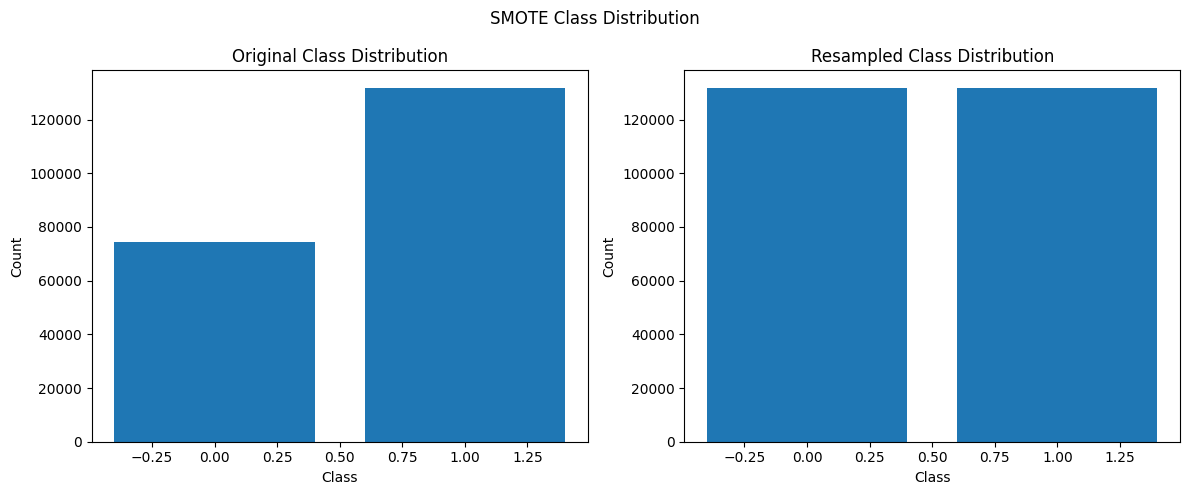

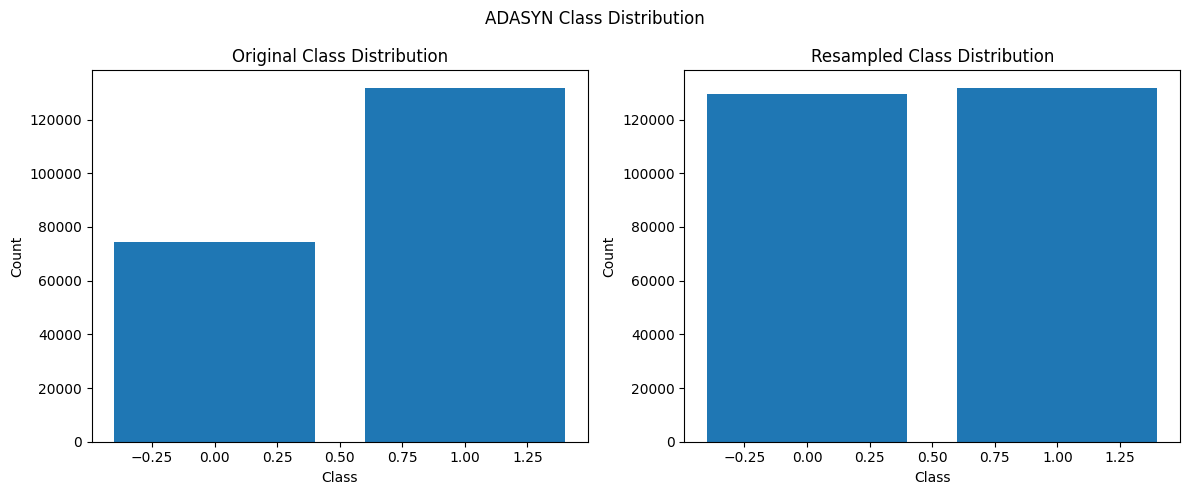

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step


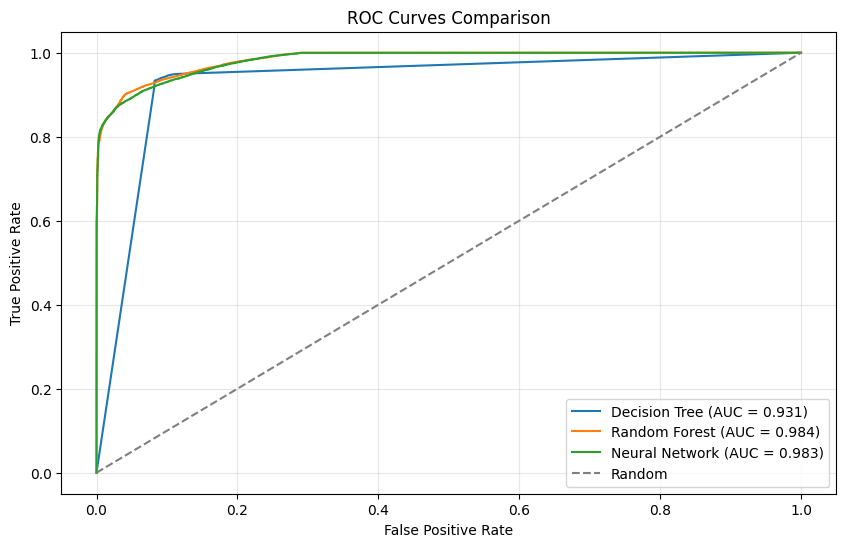

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step


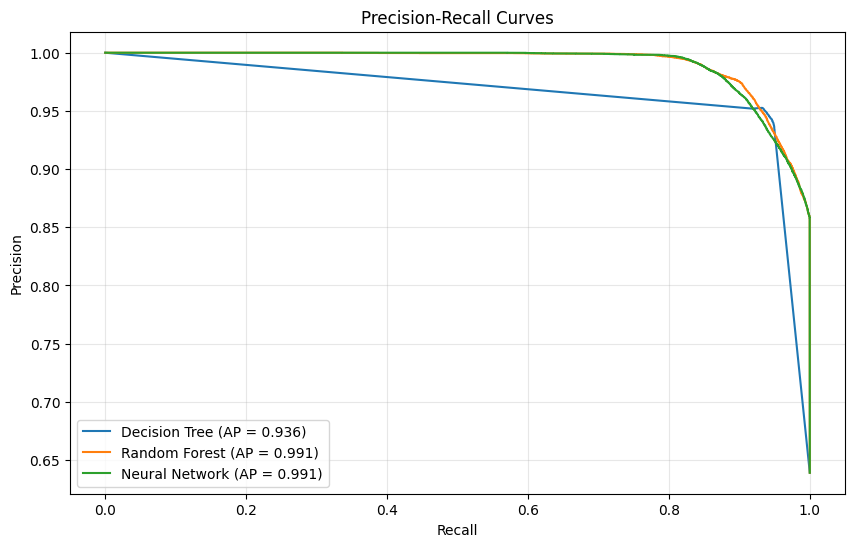

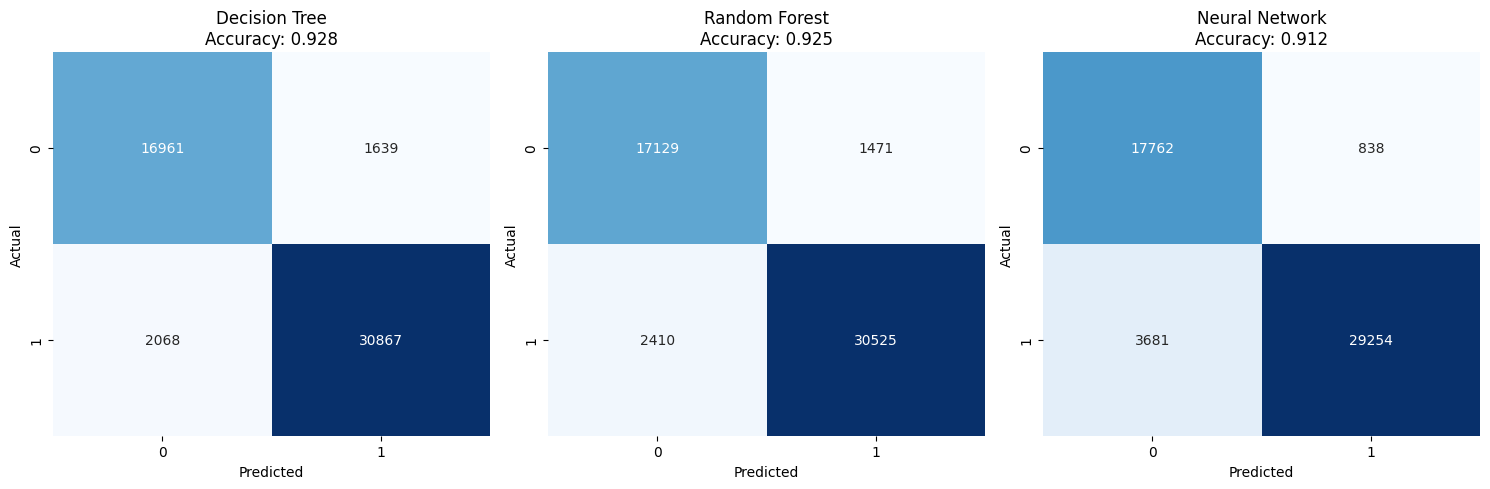

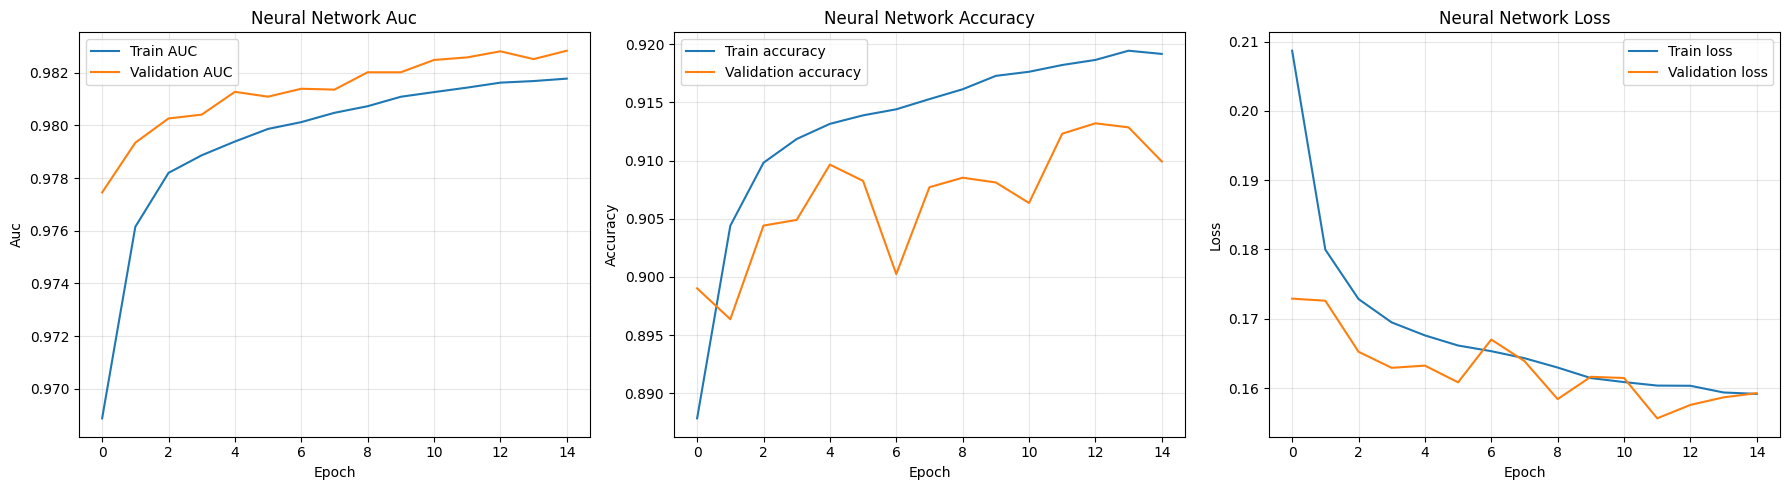


Metrics Comparison:
                Original_precision  Original_recall  Original_f1  \
Decision Tree             0.945570         0.942584     0.944074   
Random Forest             0.876415         0.991772     0.930532   
Neural Network            0.938444         0.934113     0.936273   

                Original_specificity  Original_accuracy  Original_auc_roc  \
Decision Tree               0.903925           0.928631          0.930179   
Random Forest               0.752366           0.905365          0.984382   
Neural Network              0.891505           0.918735          0.982762   

                Original_auc_pr  Original_cv_accuracy_mean  \
Decision Tree          0.934567                   0.927243   
Random Forest          0.991331                   0.906859   
Neural Network         0.990510                        NaN   

                Original_cv_accuracy_std  SMOTE_precision  ...  \
Decision Tree                   0.001266         0.952821  ...   
Random Forest   

In [8]:
# Initialize classes
model_comparator = NetworkIntrusionModelComparator(random_state=42)
oversampler = Oversampling(random_state=42)

# First, preprocess your data using your existing method
X_train, X_test, y_train, y_test = model_comparator.preprocess_data(df)

# Apply SMOTE
X_train_smote, y_train_smote = oversampler.smote(X_train, y_train)

# Apply ADASYN
X_train_adasyn, y_train_adasyn = oversampler.adasyn(X_train, y_train)

# Train and evaluate with original data
model_comparator.X_train = X_train
model_comparator.y_train = y_train
model_comparator.train_models()
original_metrics = model_comparator.evaluate_models()

# Train and evaluate with SMOTE data
model_comparator.X_train = X_train_smote
model_comparator.y_train = y_train_smote
model_comparator.train_models()
smote_metrics = model_comparator.evaluate_models()

# Train and evaluate with ADASYN data
model_comparator.X_train = X_train_adasyn
model_comparator.y_train = y_train_adasyn
model_comparator.train_models()
adasyn_metrics = model_comparator.evaluate_models()

# Visualize results
# Class distribution plots
oversampler.plot_class_distribution(y_train, y_train_smote, "SMOTE Class Distribution")
plt.show()
oversampler.plot_class_distribution(y_train, y_train_adasyn, "ADASYN Class Distribution")
plt.show()

# Plot ROC curves and other metrics using your existing methods
model_comparator.plot_roc_curves()
plt.show()
model_comparator.plot_precision_recall_curves()
plt.show()
model_comparator.plot_confusion_matrices()
plt.show()
model_comparator.plot_learning_curves()
plt.show()

# Compare metrics from different approaches
comparison_df = pd.concat([
    original_metrics.add_prefix('Original_'),
    smote_metrics.add_prefix('SMOTE_'),
    adasyn_metrics.add_prefix('ADASYN_')
], axis=1)

print("\nMetrics Comparison:")
print(comparison_df)

## GAN

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 0 | Discriminator Loss: 0.9212 | Generator Loss: 0.7190
Epoch 10 | Discriminator Loss: 0.7196 | Generator Loss: 0.6994
Epoch 20 | Discriminator Loss: 0.5625 | Generator Loss: 0.6860
Epoch 30 | Discriminator Loss: 0.4510 | Generator Loss: 0.6731
Epoch 40 | Discriminator Loss: 0.3746 | Generator Loss: 0.6582
Epoch 50 | Discriminator Loss: 0.3485 | Generator Loss: 0.6408
Epoch 60 | Discriminator Loss: 0.3261 | Generator Loss: 0.6204
Epoch 70 | Discriminator Loss: 0.3386 | Generator Loss: 0.5988
Epoch 80 | Discriminator Loss: 0.3481 | Generator Loss: 0.5740
Epoch 90 | Discriminator Loss: 0.4037 | Generator Loss: 0.5466


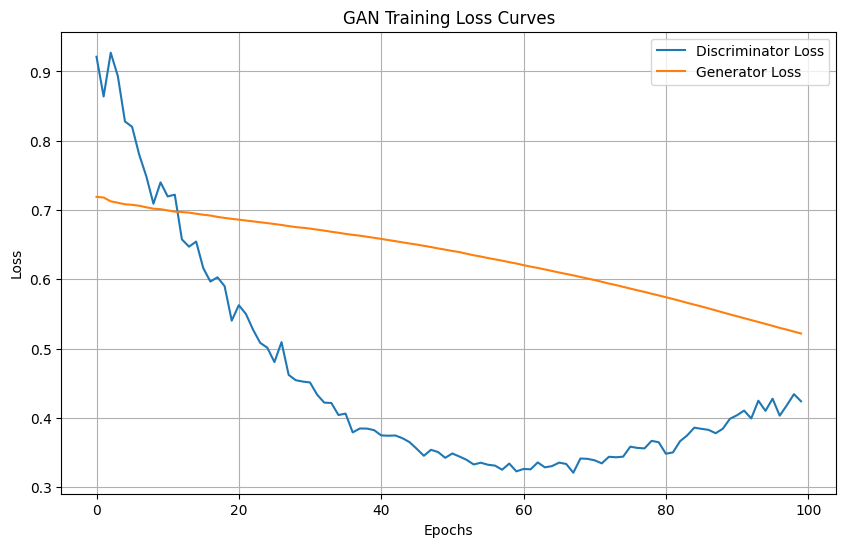

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scipy.stats import t  # Only if you need t-distribution related plots later

# Assume df, scaler, and other preprocessing steps are defined as in your original code

target_column = "label"  # Adjust this to your actual target column

# -------------------------------
# Build Discriminator
# -------------------------------
def build_discriminator(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output: probability
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

# -------------------------------
# Build Generator
# -------------------------------
def build_generator(latent_dim, output_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(latent_dim,)),
        Dense(128, activation='relu'),
        Dense(output_dim, activation='tanh')  # Output: synthetic data
    ])
    return model

# -------------------------------
# Build GAN
# -------------------------------
def build_gan(generator, discriminator, latent_dim):
    discriminator.trainable = False  # Freeze discriminator during generator training
    gan_input = Input(shape=(latent_dim,))
    generated_sample = generator(gan_input)
    gan_output = discriminator(generated_sample)
    
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

# -------------------------------
# Train GAN and record losses
# -------------------------------
def train_gan(generator, discriminator, gan, X_train, latent_dim, epochs=100, batch_size=32):
    half_batch = batch_size // 2

    # Lists to store losses for plotting
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        # --------- Train Discriminator ---------
        # Set discriminator trainable and compile before training it
        discriminator.trainable = True
        discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        
        # Select a random half-batch of real samples
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_samples = X_train[idx]

        # Generate fake samples using the generator
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_samples = generator.predict(noise, verbose=0)

        # Train on real and fake samples
        d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # --------- Train Generator ---------
        # Freeze discriminator weights for GAN training
        discriminator.trainable = False  
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Discriminator Loss: {d_loss[0]:.4f} | Generator Loss: {g_loss:.4f}")

    return d_losses, g_losses

# -------------------------------
# Main Execution
# -------------------------------

# Assuming your dataframe 'df' is already loaded and preprocessed
# Example: X_scaled = scaler.fit_transform(df.drop(columns=[target_column]))

input_dim = X_scaled.shape[1]
latent_dim = 10  # You can adjust this based on your data/model

discriminator = build_discriminator(input_dim)
generator = build_generator(latent_dim, input_dim)
gan = build_gan(generator, discriminator, latent_dim)

# Train the GAN and get the loss values
epochs = 100
batch_size = 32
d_losses, g_losses = train_gan(generator, discriminator, gan, X_scaled, latent_dim, epochs=epochs, batch_size=batch_size)

# -------------------------------
# Plot the Loss Curves
# -------------------------------
plt.figure(figsize=(10, 6))
epochs_range = range(epochs)
plt.plot(epochs_range, d_losses, label='Discriminator Loss')
plt.plot(epochs_range, g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


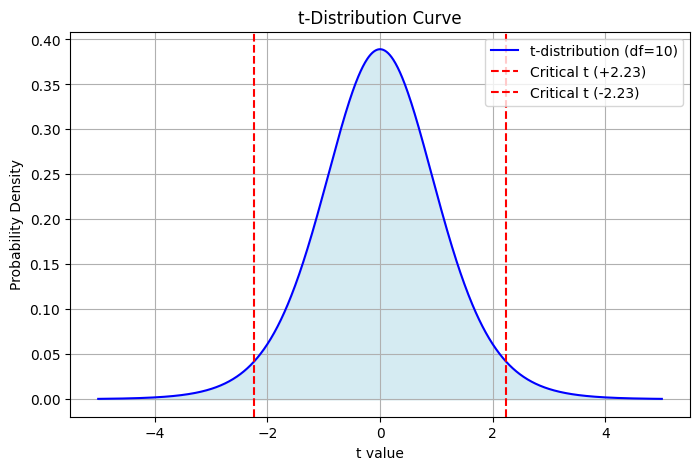

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Set degrees of freedom
df = 10  # Change to your desired degrees of freedom

# Generate an array of t values
t_values = np.linspace(-5, 5, 1000)

# Compute the t-distribution PDF for these t values
pdf_values = t.pdf(t_values, df)

# Plot the t-distribution curve
plt.figure(figsize=(8, 5))
plt.plot(t_values, pdf_values, label=f"t-distribution (df={df})", color='blue')
plt.fill_between(t_values, pdf_values, color='lightblue', alpha=0.5)

# Optionally, calculate a critical t value for a given significance level (e.g., 95% confidence)
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df)
plt.axvline(t_critical, color='red', linestyle='--', label=f"Critical t (+{t_critical:.2f})")
plt.axvline(-t_critical, color='red', linestyle='--', label=f"Critical t (-{t_critical:.2f})")

plt.title("t-Distribution Curve")
plt.xlabel("t value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()


2025-02-02 15:37:01,691 - INFO - Starting data preprocessing...
2025-02-02 15:37:01,746 - INFO - Found 3 categorical and 31 numerical columns
2025-02-02 15:37:03,011 - INFO - Final preprocessed shape: (257673, 188)
2025-02-02 15:37:03,012 - INFO - Train set size: 206138, Test set size: 51535


Expected feature set (n=188): ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes'] ...
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9120 - loss: 0.2977 - val_accuracy: 0.9171 - val_loss: 0.1816
Epoch 2/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9142 - loss: 0.1753 - val_accuracy: 0.9164 - val_loss: 0.1588
Epoch 3/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9141 - loss: 0.1610 - val_accuracy: 0.9171 - val_loss: 0.1548
Epoch 4/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9130 - loss: 0.1613 - val_accuracy: 0.9177 - val_loss: 0.1536
Epoch 5/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9135 - loss: 0.1615 - val_accuracy: 0.9169 - val_loss: 0.1531
Epoch 6/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9149 - loss: 0.1560 - val_accuracy: 0.9171 - val_loss: 0.1527
Epoch 7/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9157 - loss: 0.1564 - val_accuracy: 0.9174 - val_loss: 0.1522
Epoch 8/20
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 8s 1

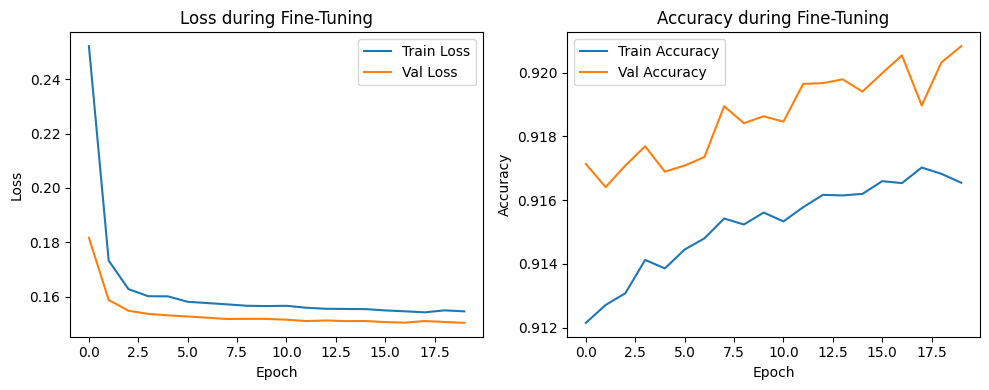

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

# ---------------------------------------------------------------------
# ASSUMPTION:
# You have a preprocessing pipeline that you used previously for training,
# for example via a class like NetworkIntrusionModelComparator.
# It produces X_train (a DataFrame with the correct feature set) when called.
# ---------------------------------------------------------------------

# Import your custom classes (adjust the import statement as needed)
# from your_module import NetworkIntrusionModelComparator, Oversampling

# -------------------------------
# 1. Preprocess Data Using the Previous Pipeline
# -------------------------------
# Initialize the comparator (this should do the same preprocessing as used during training)
model_comparator = NetworkIntrusionModelComparator(random_state=42)
X_train, X_test, y_train, y_test = model_comparator.preprocess_data(df)

# Extract the expected feature names (e.g. 188 features) from the training data
expected_features = list(X_train.columns)
print(f"Expected feature set (n={len(expected_features)}): {expected_features[:5]} ...")

# For synthetic data generation and fine-tuning, we’ll use the processed training data.
# (You could also use the full dataset if desired.)
df_processed = X_train.copy()  # This DataFrame now has the same features as used originally

# -------------------------------
# 2. Scale the Features
# -------------------------------
# Fit a scaler on the processed training data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_processed)
# X_scaled now has shape (n_samples, len(expected_features))

# -------------------------------
# 3. Load the Pre-Trained Classifier
# -------------------------------
classifier = load_model('network_intrusion_adasyn.keras')

# -------------------------------
# 4. Define the GAN Generator
# -------------------------------
# The generator must output vectors with the same number of features (columns) as expected.
latent_dim = 10  # This should match what was used during GAN training

generator = Sequential([
    Dense(128, input_dim=latent_dim),
    LeakyReLU(negative_slope=0.2),  # use negative_slope instead of the deprecated alpha
    BatchNormalization(momentum=0.8),
    
    Dense(64),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(momentum=0.8),
    
    # The output layer must produce vectors with dimension equal to the number of features
    Dense(len(expected_features), activation='tanh')
])

# -------------------------------
# 5. Generate Synthetic Data
# -------------------------------
num_synthetic_samples = 1000

# Generate random noise
noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))

# Generate synthetic samples
synthetic_data = generator.predict(noise, verbose=1)

# Confirm the generator produced the expected number of features
if synthetic_data.shape[1] != X_scaled.shape[1]:
    raise ValueError(f"Generator output shape {synthetic_data.shape} does not match expected shape (n_samples, {X_scaled.shape[1]})")

# Inverse-transform synthetic data so that it is on the same scale as the original features
synthetic_data = scaler.inverse_transform(synthetic_data)

# -------------------------------
# 6. Prepare Synthetic Labels
# -------------------------------
# Compute the label distribution from the training data
unique_labels, counts = np.unique(y_train, return_counts=True)
label_probabilities = counts / counts.sum()

# Assign labels to synthetic samples according to that distribution
synthetic_labels = np.random.choice(unique_labels, size=num_synthetic_samples, p=label_probabilities)

# -------------------------------
# 7. Combine Real and Synthetic Data
# -------------------------------
# Use the inverse-transformed real training data for consistency
X_real = scaler.inverse_transform(X_scaled)
y_real = y_train  # from your previous pipeline

# Concatenate the real and synthetic data and labels
X_combined = np.concatenate([X_real, synthetic_data], axis=0)
y_combined = np.concatenate([y_real, synthetic_labels], axis=0)

# Shuffle the combined dataset
indices = np.arange(X_combined.shape[0])
np.random.shuffle(indices)
X_combined = X_combined[indices]
y_combined = y_combined[indices]

# Ensure no NaN or infinite values remain
X_combined = np.nan_to_num(X_combined)

# -------------------------------
# 8. Fine-Tune the Classifier
# -------------------------------
classifier.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = classifier.fit(
    X_combined,
    y_combined,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

# -------------------------------
# 9. Plot Training History
# -------------------------------
plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
